# Construcció del conjunt de dades agregat per client

Per tal de poder aplicar tècniques de clustering i identificar patrons de comportament entre clients, és necessari primer construir una taula on cada fila representi un client únic, i cada columna reculli una característica agregada rellevant del seu comportament de compra.

A partir de les dades transaccionals originals, s’ha realitzat una agregació per CustomerID que inclou:

Mètriques de despesa i quantitat (quantitat total, preu mitjà, despesa online/offline).

Antiguitat i nombre total de compres.

Diversitat de productes comprats.

Localització principal del client.

Proporció de compres per categoria de producte.

Aquesta taula resultant serà la base per aplicar els algorismes de clustering en els punts posteriors.

In [1]:
import pandas as pd

# Carrega el dataset
df = pd.read_csv("data/df_preparat.csv")

# Eliminació de duplicats per seguretat
df_clean = df.drop_duplicates()

# Variables de localització
location_cols = [col for col in df_clean.columns if col.startswith("Loc_")]

# Variables de categoria de producte
cat_cols = [col for col in df_clean.columns if col.startswith("Cat_")]

# Agrupació per client
client_agg = df_clean.groupby("CustomerID").agg({
    "Quantity": "sum",
    "Avg_Price": "mean",
    "Online_Spend": "sum",
    "Offline_Spend": "sum",
    "Discount_pct": "mean",
    "Tenure_Months": "first",
    "Product_SKU": pd.Series.nunique,
    "Transaction_ID": "count"
}).rename(columns={
    "Quantity": "Total_Quantity",
    "Avg_Price": "Avg_Price",
    "Online_Spend": "Total_Online_Spend",
    "Offline_Spend": "Total_Offline_Spend",
    "Discount_pct": "Avg_Discount_pct",
    "Tenure_Months": "Tenure_Months",
    "Product_SKU": "Unique_Products",
    "Transaction_ID": "Num_Transactions"
})

# Localització principal (la de més compres)
client_locations = df_clean.groupby("CustomerID")[location_cols].sum()
client_locations = client_locations.idxmax(axis=1).str.replace("Loc_", "")
client_agg["Primary_Location"] = client_locations

# Proporció de compres per categoria de producte
client_cats = df_clean.groupby("CustomerID")[cat_cols].mean()
client_agg = client_agg.join(client_cats)

# Exportació a CSV
client_agg.to_csv("data/clients_agrupats.csv")

# Mostrar una mostra
print(client_agg)


            Total_Quantity   Avg_Price  Total_Online_Spend  \
CustomerID                                                   
12346.0                3.0   12.745000             5093.34   
12347.0              342.0   62.436000           127339.54   
12348.0              209.0   14.631304            47477.33   
12350.0               21.0   77.200000            58383.27   
12356.0               56.0   34.578611            91680.12   
...                    ...         ...                 ...   
18259.0               46.0   12.104286            16398.76   
18260.0              141.0   27.872250            95583.17   
18269.0               10.0   11.167500            17418.35   
18277.0                2.0  149.000000             1153.81   
18283.0              155.0   55.470588           243910.11   

            Total_Offline_Spend  Avg_Discount_pct  Tenure_Months  \
CustomerID                                                         
12346.0                  6000.0         30.000000        

# Normalització de les dades per a clustering
Abans d’aplicar els algorismes de clustering, és necessari assegurar-se que totes les variables tinguin la mateixa escala. Com que el conjunt de dades conté valors de naturalesa molt diferent (quantitat de compres, despesa total, proporcions per categoria, etc.), s’aplica un escalat estàndard (z-score) mitjançant StandardScaler de la llibreria scikit-learn. Aquest procés transforma cada variable perquè tingui mitjana zero i desviació estàndard u, evitant que cap variable dominin el càlcul de distàncies.

In [2]:
from sklearn.preprocessing import StandardScaler

# Selecció de variables numèriques per clustering
features = client_agg.select_dtypes(include=['float64', 'int64']).drop(columns=["Top_Month"], errors="ignore")

# Escalat
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Comparació de combinacions de variables per al clustering de clients
Per tal de determinar quines característiques dels clients ofereixen una segmentació més clara i útil, s'han provat diverses combinacions de variables en l'aplicació de l’algorisme K-Means. Per cada combinació, s'ha avaluat la qualitat dels grups obtinguts mitjançant el Silhouette Score. A continuació, es mostra la comparació entre les estratègies, així com una visualització dels grups formats per una de les combinacions seleccionades.


--- Millors combinacions i valors de k ---
Combinació: basiques                  | Vars: 6  | k òptim: 6 | Silhouette: 0.228
Combinació: només_comportament        | Vars: 7  | k òptim: 8 | Silhouette: 0.215
Combinació: comportament_temporals    | Vars: 7  | k òptim: 8 | Silhouette: 0.215
Combinació: comportament_diversitat   | Vars: 8  | k òptim: 10 | Silhouette: 0.210
Combinació: comportament_categories   | Vars: 27 | k òptim: 4 | Silhouette: 0.098
Combinació: complet_sense_temporals   | Vars: 28 | k òptim: 6 | Silhouette: 0.097
Combinació: tot_inclòs                | Vars: 28 | k òptim: 6 | Silhouette: 0.097
Combinació: només_categories          | Vars: 20 | k òptim: 10 | Silhouette: 0.073


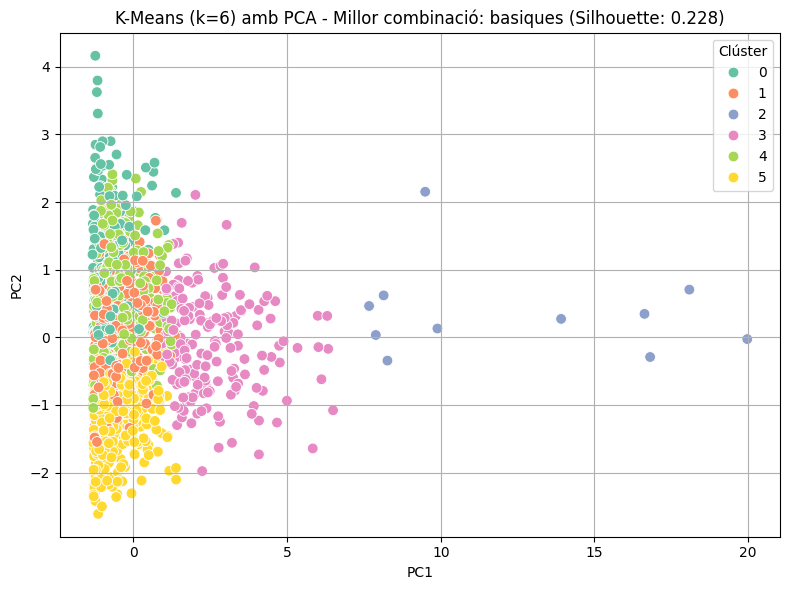

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ─────────────────────────────────────────────────────────────
# Blocs de variables
comportament = [
    "Total_Quantity", "Total_Online_Spend", "Total_Offline_Spend",
    "Avg_Price", "Avg_Discount_pct", "Num_Transactions", "Tenure_Months"
]
diversitat = ["Unique_Products"]
categories = [col for col in client_agg.columns if col.startswith("Cat_")]
temporals = ["Top_Month"] if "Top_Month" in client_agg.columns else []

# ─────────────────────────────────────────────────────────────
# Combinacions a provar
combinations = {
    "només_comportament": comportament,
    "comportament_diversitat": comportament + diversitat,
    "comportament_temporals": comportament + temporals,
    "comportament_categories": comportament + categories,
    "complet_sense_temporals": comportament + diversitat + categories,
    "tot_inclòs": comportament + diversitat + categories + temporals,
    "només_categories": categories,
    "basiques": [
        "Total_Online_Spend", "Total_Offline_Spend", "Avg_Price",
        "Avg_Discount_pct", "Unique_Products", "Tenure_Months"
    ]
}

# ─────────────────────────────────────────────────────────────
# Prova de múltiples valors de k
k_values = [4, 6, 8, 10]
results = []

for name, columns in combinations.items():
    # Filtrar només columnes numèriques disponibles
    available_cols = [col for col in columns if col in client_agg.columns]
    X = client_agg[available_cols].select_dtypes(include=["number"]).dropna()
    if X.shape[0] < 10 or X.shape[1] < 2:
        continue  # saltem si hi ha massa poques dades

    # Escalat
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prova valors de k
    best_k = None
    best_score = -1
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)

        if score > best_score:
            best_score = score
            best_k = k

    results.append((name, len(available_cols), best_k, best_score))

# ─────────────────────────────────────────────────────────────
# Mostrar resultats
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

print("\n--- Millors combinacions i valors de k ---")
for name, n_cols, best_k, score in results_sorted:
    print(f"Combinació: {name:<25} | Vars: {n_cols:<2} | k òptim: {best_k} | Silhouette: {score:.3f}")

# ─────────────────────────────────────────────────────────────
# Visualització amb PCA per la millor combinació
best_name, best_n_cols, best_k, best_score = results_sorted[0]
columns = combinations[best_name]
available_cols = [col for col in columns if col in client_agg.columns]

X = client_agg[available_cols].select_dtypes(include=["number"]).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=60)
plt.title(f"K-Means (k={best_k}) amb PCA - Millor combinació: {best_name} (Silhouette: {best_score:.3f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clúster")
plt.grid(True)
plt.tight_layout()
plt.show()


# Aplicació de l’algorisme DBSCAN per a la detecció de clústers basats en densitat
A diferència de K-Means, DBSCAN no necessita especificar prèviament el nombre de clústers. Per seleccionar el valor del paràmetre eps, s’ha utilitzat el mètode del k-distance, analitzant la distància al cinquè veí més proper per detectar un canvi de pendent. Un cop seleccionat eps, s’ha aplicat DBSCAN per detectar agrupacions denses i possibles outliers entre els clients.


--- Resultats DBSCAN per combinació ---
només_categories          | Vars: 20 | Clústers: 4  | Outliers: 565 | Silhouette: 0.588
comportament_categories   | Vars: 27 | Clústers: 5  | Outliers: 1181 | Silhouette: 0.082
complet_sense_temporals   | Vars: 28 | Clústers: 8  | Outliers: 1201 | Silhouette: 0.063
tot_inclòs                | Vars: 28 | Clústers: 8  | Outliers: 1201 | Silhouette: 0.063
només_comportament        | Vars: 7  | Clústers: 1  | Outliers: 41  | Silhouette: N/A
comportament_diversitat   | Vars: 8  | Clústers: 1  | Outliers: 51  | Silhouette: N/A
comportament_temporals    | Vars: 7  | Clústers: 1  | Outliers: 41  | Silhouette: N/A
basiques                  | Vars: 6  | Clústers: 1  | Outliers: 21  | Silhouette: N/A


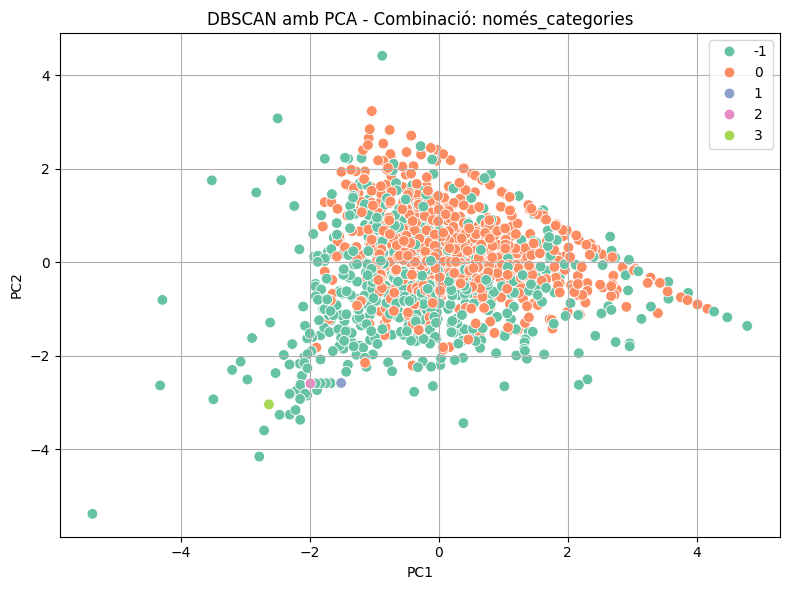

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuració
eps = 1.5
min_samples = 5

dbscan_results = []

for name, columns in combinations.items():
    available_cols = [col for col in columns if col in client_agg.columns]
    X = client_agg[available_cols].select_dtypes(include=["number"]).dropna()
    if X.shape[0] < 10 or X.shape[1] < 2:
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    # Comptar clústers vàlids
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = (labels == -1).sum()

    # Silhouette
    mask = labels != -1
    if n_clusters >= 2:
        score = silhouette_score(X_scaled[mask], labels[mask])
    else:
        score = None

    dbscan_results.append((name, len(available_cols), n_clusters, n_outliers, score))

# Mostrar resultats
dbscan_results_sorted = sorted(dbscan_results, key=lambda x: (x[4] if x[4] is not None else -1), reverse=True)

print("\n--- Resultats DBSCAN per combinació ---")
for name, n_cols, n_clust, n_out, score in dbscan_results_sorted:
    score_str = f"{score:.3f}" if score else "N/A"
    print(f"{name:<25} | Vars: {n_cols:<2} | Clústers: {n_clust:<2} | Outliers: {n_out:<3} | Silhouette: {score_str}")

# Visualització per la millor combinació
best_name, _, _, _, _ = dbscan_results_sorted[0]
columns = combinations[best_name]
X = client_agg[[col for col in columns if col in client_agg.columns]].select_dtypes(include="number").dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_scaled)

X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=60)
plt.title(f"DBSCAN amb PCA - Combinació: {best_name}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Segmentació de clients mitjançant clustering jeràrquic aglomeratiu

El clustering jeràrquic permet construir una jerarquia de grups a partir de les distàncies entre observacions. En aquest cas, s’ha aplicat la versió aglomerativa (bottom-up), on inicialment cada client representa un clúster propi i es van fusionant segons una mesura de similitud. Aquest mètode no requereix normalització prèvia de les dades, però en aquest treball s’ha utilitzat després d’escalar les variables per coherència amb la resta d’algorismes. S’ha seleccionat un valor de k=6 per facilitar la comparació amb K-Means. Es calcula també el Silhouette Score per avaluar la qualitat de la segmentació.


--- Resultats Clustering Jeràrquic ---
només_comportament        | Vars: 7  | Clústers: 6 | Silhouette: 0.174
comportament_temporals    | Vars: 7  | Clústers: 6 | Silhouette: 0.174
basiques                  | Vars: 6  | Clústers: 6 | Silhouette: 0.170
comportament_diversitat   | Vars: 8  | Clústers: 6 | Silhouette: 0.167
només_categories          | Vars: 20 | Clústers: 6 | Silhouette: 0.142
complet_sense_temporals   | Vars: 28 | Clústers: 6 | Silhouette: 0.076
tot_inclòs                | Vars: 28 | Clústers: 6 | Silhouette: 0.076
comportament_categories   | Vars: 27 | Clústers: 6 | Silhouette: 0.075


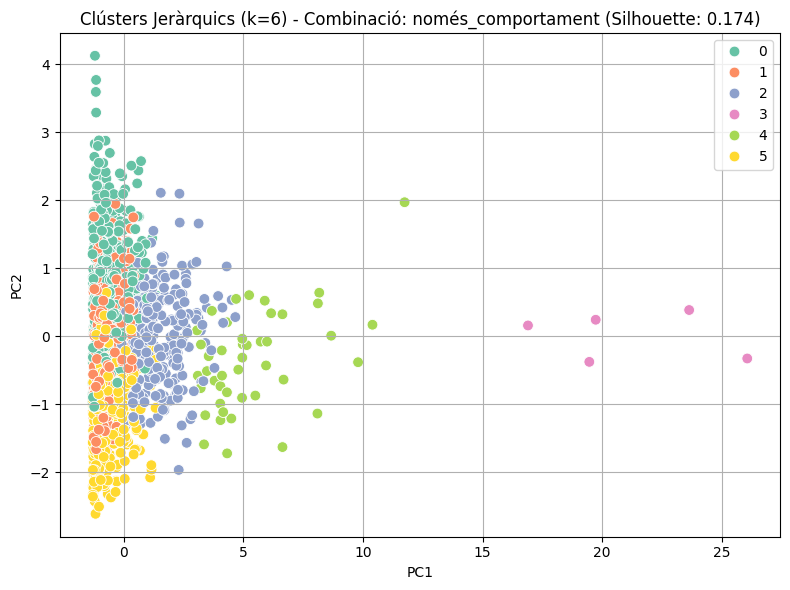

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Nombre fix de clústers
k_hier = 6
hier_results = []

for name, columns in combinations.items():
    available_cols = [col for col in columns if col in client_agg.columns]
    X = client_agg[available_cols].select_dtypes(include=["number"]).dropna()
    if X.shape[0] < 10 or X.shape[1] < 2:
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model_hier = AgglomerativeClustering(n_clusters=k_hier)
    labels = model_hier.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)

    hier_results.append((name, len(available_cols), k_hier, score))

# Ordenar per Silhouette Score
hier_results_sorted = sorted(hier_results, key=lambda x: x[3], reverse=True)

print("\n--- Resultats Clustering Jeràrquic ---")
for name, n_cols, k, score in hier_results_sorted:
    print(f"{name:<25} | Vars: {n_cols:<2} | Clústers: {k} | Silhouette: {score:.3f}")

# Visualització per la millor combinació
best_name, _, _, best_score = hier_results_sorted[0]
columns = combinations[best_name]
X = client_agg[[col for col in columns if col in client_agg.columns]].select_dtypes(include="number").dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
labels = AgglomerativeClustering(n_clusters=k_hier).fit_predict(X_scaled)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=60)
plt.title(f"Clústers Jeràrquics (k={k_hier}) - Combinació: {best_name} (Silhouette: {best_score:.3f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Segmentació de clients amb models de mescles gaussianes (GMM)
Els models de mescles gaussianes (GMM) són una extensió probabilística del clustering tradicional. En lloc d’assignar cada observació a un únic clúster, GMM estima la probabilitat que cada punt pertanyi a cadascun dels clústers. Això permet modelar grups amb formes el·líptiques o no esfèriques, millorant en alguns casos les limitacions de K-Means. S’ha utilitzat el mateix nombre de clústers (k=6) per a la comparació directa, i el Silhouette Score com a mètrica de qualitat.


--- Resultats Gaussian Mixture Model ---
basiques                  | Vars: 6  | Clústers: 6 | Silhouette: 0.063
comportament_diversitat   | Vars: 8  | Clústers: 6 | Silhouette: 0.061
només_comportament        | Vars: 7  | Clústers: 6 | Silhouette: 0.055
comportament_temporals    | Vars: 7  | Clústers: 6 | Silhouette: 0.055
complet_sense_temporals   | Vars: 28 | Clústers: 6 | Silhouette: 0.054
tot_inclòs                | Vars: 28 | Clústers: 6 | Silhouette: 0.054
comportament_categories   | Vars: 27 | Clústers: 6 | Silhouette: 0.000
només_categories          | Vars: 20 | Clústers: 6 | Silhouette: -0.036


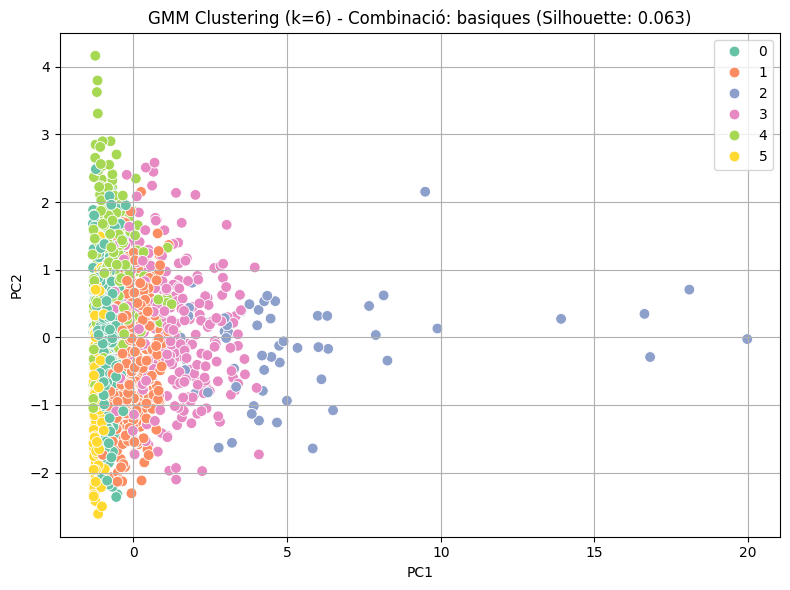

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Nombre de components
k_gmm = 6
gmm_results = []

for name, columns in combinations.items():
    available_cols = [col for col in columns if col in client_agg.columns]
    X = client_agg[available_cols].select_dtypes(include=["number"]).dropna()
    if X.shape[0] < 10 or X.shape[1] < 2:
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=k_gmm, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)

    gmm_results.append((name, len(available_cols), k_gmm, score))

# Ordenar per Silhouette Score
gmm_results_sorted = sorted(gmm_results, key=lambda x: x[3], reverse=True)

print("\n--- Resultats Gaussian Mixture Model ---")
for name, n_cols, k, score in gmm_results_sorted:
    print(f"{name:<25} | Vars: {n_cols:<2} | Clústers: {k} | Silhouette: {score:.3f}")

# Visualització del millor cas
best_name, _, _, best_score = gmm_results_sorted[0]
columns = combinations[best_name]
X = client_agg[[col for col in columns if col in client_agg.columns]].select_dtypes(include="number").dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
labels = GaussianMixture(n_components=k_gmm, random_state=42).fit_predict(X_scaled)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=60)
plt.title(f"GMM Clustering (k={k_gmm}) - Combinació: {best_name} (Silhouette: {best_score:.3f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Segmentació de clients mitjançant HDBSCAN: una aproximació robusta basada en densitat

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) és una evolució de DBSCAN que permet detectar automàticament el nombre de clústers a partir de la densitat local de punts. A diferència de K-Means o GMM, no cal especificar k, i també gestiona outliers de manera explícita. Aquesta tècnica és especialment útil en conjunts de dades on els grups tenen densitats desiguals. La qualitat de la segmentació es valida amb el Silhouette Score, sempre que hi hagi més d’un clúster vàlid.

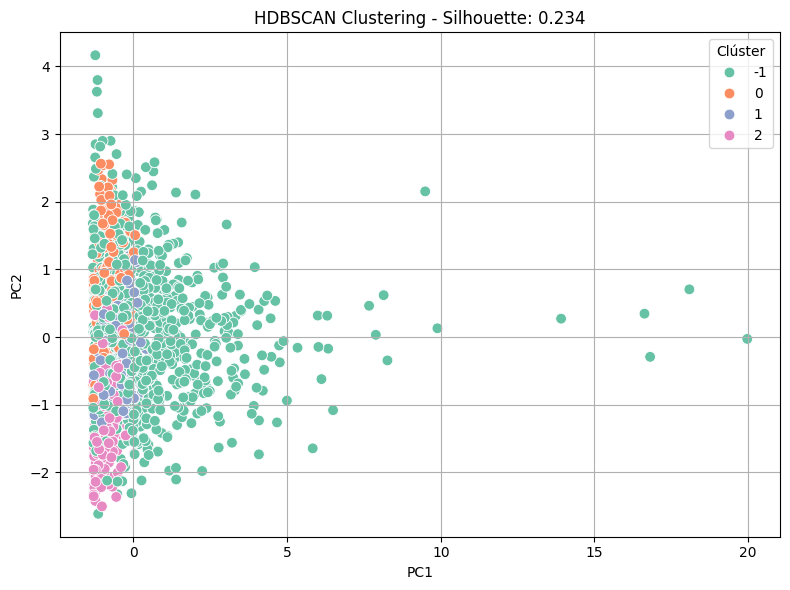

In [7]:
import hdbscan

# Aplicació de HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
labels_hdb = hdb.fit_predict(X_scaled)

# Silhouette només si hi ha clústers vàlids
mask = labels_hdb != -1
if len(set(labels_hdb[mask])) >= 2:
    score_hdb = silhouette_score(X_scaled[mask], labels_hdb[mask])
else:
    score_hdb = None

# Visualització amb PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_hdb, palette="Set2", s=60)
plt.title(
    f"HDBSCAN Clustering - Silhouette: {score_hdb:.3f}" if score_hdb else "HDBSCAN - Silhouette no aplicable"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clúster")
plt.grid(True)
plt.tight_layout()
plt.show()
